### load python packages

In [1]:
import keras
import tensorflow as tf
import pyfaidx
import math
import pandas as pd
import tqdm
import numpy as np
import deepdish
import pyBigWig
import scipy
from modisco.visualization import viz_sequence
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import logomaker
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="6"

2022-06-22 19:03:09.643707: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


### Load Data

In [2]:
genome = pyfaidx.Fasta('/users/surag/genomes/mm10/mm10.fa')
seqs = np.load("/mnt/lab_data3/surag/kundajelab/playground/src/analyses/20220427_hit_scoring_NN/out/v1/spoof_seqs.npy")
labels = np.load("/mnt/lab_data3/surag/kundajelab/playground/src/analyses/20220427_hit_scoring_NN/out/v1/labels.npy")


In [10]:
labels.shape

(20000, 2114, 11)

### shuffle the dataset and create 8:1:1 train val test splits

In [11]:
idxs = np.array(range(seqs.shape[0]))
np.random.shuffle(idxs)
train_idxs = idxs[:int(0.8*len(idxs))]
val_idxs = idxs[int(0.8*len(idxs)):int(0.9*len(idxs))]
test_idxs = idxs[int(0.9*len(idxs)):]

train_seqs = seqs[train_idxs]
train_labels = labels[train_idxs]

val_seqs = seqs[val_idxs]
val_labels = labels[val_idxs]

test_seqs = seqs[test_idxs]
test_labels = labels[test_idxs]

### Define model

In [13]:
def model_3conv(channels=50, blocks=8):
    inp = tf.keras.Input((2114,4))
    x = tf.keras.layers.Conv1D(channels, 20, padding='same', activation='relu')(inp)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    
    for i in range(blocks):
        x1 = tf.keras.layers.Conv1D(channels, 15, padding='same', activation='relu')(x)
        x1 = tf.keras.layers.BatchNormalization()(x1)
        x1 = tf.keras.layers.Dropout(0.2)(x1)
        x = tf.keras.layers.Add()([x,x1])
    
    x = tf.keras.layers.Dense(11)(x)
    

    return tf.keras.Model(inputs=inp, outputs=x)


In [14]:
model = model_3conv()

2022-06-22 19:10:33.185720: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-22 19:10:33.189986: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-06-22 19:10:33.311613: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-06-22 19:10:33.311726: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: krishna
2022-06-22 19:10:33.311750: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: krishna
2022-06-22 19:10:33.312043: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.129.6
2022-06-22 19:10:33.312148: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.129.6
2022-06-22 19:10:33.312172: I tensorflow/stream_executor/cuda

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2114, 4)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 2114, 50)     4050        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 2114, 50)     200         conv1d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2114, 50)     0           batch_normalization[0][0]        
______________________________________________________________________________________________

### train model

In [9]:
model = model_3conv()
cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
def acc_within_nonbg(y_true, y_pred):
    return tf.reduce_mean(tf.cast(tf.equal(tf.math.argmax(y_true, -1), tf.math.argmax(y_pred, -1))[tf.math.argmax(y_true, -1) != 10],
                                  tf.float32))

model.compile(
    optimizer="adam",
    loss=cce,
    metrics=[tf.keras.metrics.CategoricalAccuracy(), acc_within_nonbg],
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc_within_nonbg', factor=0.2,
                              patience=5, min_lr=0.0001)
model.fit(train_seqs,
          train_labels,
         batch_size=128,
         epochs=50,
         validation_data=(val_seqs, val_labels),
         callbacks=reduce_lr,
         shuffle=True)

2022-06-21 12:27:10.209283: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1488256000 exceeds 10% of free system memory.
2022-06-21 12:27:11.841511: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-06-21 12:27:11.862542: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2593845000 Hz


Epoch 1/50


2022-06-21 12:27:15.275271: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-06-21 12:27:15.624561: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-06-21 12:27:15.634164: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


125/125 [==============================] - 46s 311ms/step - loss: 1.5245 - categorical_accuracy: 0.8317 - acc_within_nonbg: 0.1953 - val_loss: 0.2219 - val_categorical_accuracy: 0.9679 - val_acc_within_nonbg: 0.0000e+00
Epoch 2/50
125/125 [==============================] - 39s 313ms/step - loss: 0.1017 - categorical_accuracy: 0.9786 - acc_within_nonbg: 0.4926 - val_loss: 0.2320 - val_categorical_accuracy: 0.9679 - val_acc_within_nonbg: 0.0000e+00
Epoch 3/50
125/125 [==============================] - 41s 326ms/step - loss: 0.0586 - categorical_accuracy: 0.9843 - acc_within_nonbg: 0.6791 - val_loss: 0.2525 - val_categorical_accuracy: 0.9679 - val_acc_within_nonbg: 1.0232e-04
Epoch 4/50
125/125 [==============================] - 41s 329ms/step - loss: 0.0530 - categorical_accuracy: 0.9851 - acc_within_nonbg: 0.7045 - val_loss: 0.1828 - val_categorical_accuracy: 0.9685 - val_acc_within_nonbg: 0.0174
Epoch 5/50
125/125 [==============================] - 41s 329ms/step - loss: 0.0392 - categ

Epoch 37/50
125/125 [==============================] - 41s 325ms/step - loss: 0.0164 - categorical_accuracy: 0.9934 - acc_within_nonbg: 0.8855 - val_loss: 0.0171 - val_categorical_accuracy: 0.9941 - val_acc_within_nonbg: 0.9014
Epoch 38/50
125/125 [==============================] - 40s 321ms/step - loss: 0.0168 - categorical_accuracy: 0.9933 - acc_within_nonbg: 0.8824 - val_loss: 0.0170 - val_categorical_accuracy: 0.9942 - val_acc_within_nonbg: 0.9040
Epoch 39/50
125/125 [==============================] - 40s 321ms/step - loss: 0.0167 - categorical_accuracy: 0.9933 - acc_within_nonbg: 0.8828 - val_loss: 0.0156 - val_categorical_accuracy: 0.9942 - val_acc_within_nonbg: 0.9006
Epoch 40/50
125/125 [==============================] - 40s 321ms/step - loss: 0.0163 - categorical_accuracy: 0.9934 - acc_within_nonbg: 0.8862 - val_loss: 0.0161 - val_categorical_accuracy: 0.9942 - val_acc_within_nonbg: 0.8963
Epoch 41/50
125/125 [==============================] - 40s 323ms/step - loss: 0.0166 - c

### calculate accuracy on test set and visualize confusion matrix

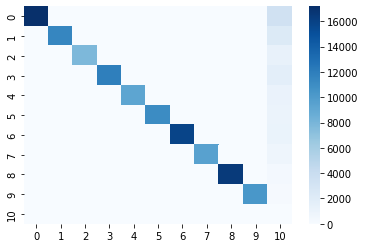

In [10]:
test_pred = model.predict(test_seqs)
acc_within_nonbg(test_labels, test_pred).numpy()
conf_mat = confusion_matrix((np.argmax(test_labels, -1)[np.argmax(test_labels, -1)!=10]).flatten(), 
                            (np.argmax(test_pred, -1)[np.argmax(test_labels, -1)!=10]).flatten())

ax = sns.heatmap(conf_mat, annot=False, cmap='Blues')

### visualize prediction on test set

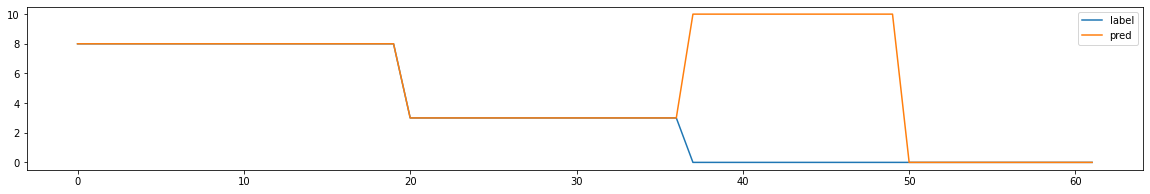

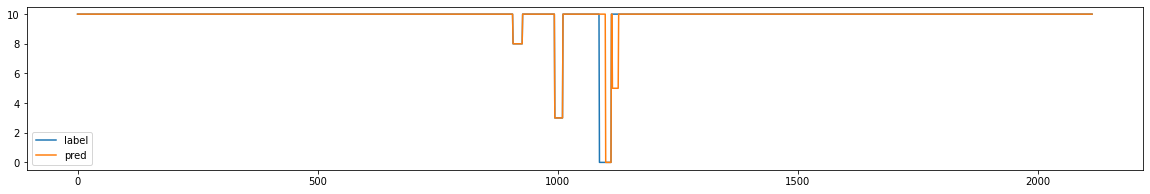

In [31]:
plt.rcParams["figure.figsize"] = (20,3)
IDX=800
plt.plot(np.argmax(test_labels[IDX], -1)[np.argmax(test_labels[IDX], -1)!=10], label='label')
plt.plot(np.argmax(test_pred[IDX], -1)[np.argmax(test_labels[IDX], -1)!=10], label='pred')
plt.legend()
plt.show()

plt.plot(np.argmax(test_labels[IDX], -1), label='label')
plt.plot(np.argmax(test_pred[IDX], -1), label='pred')
plt.legend()
plt.show()

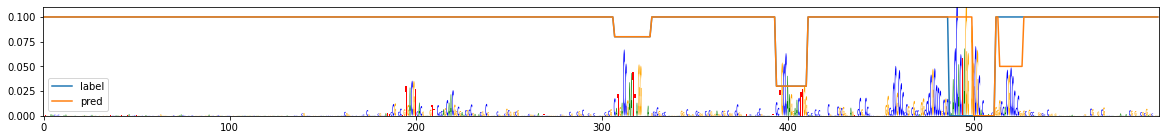

In [33]:
IDX=800
fig, ax = plt.subplots(1, figsize=(20,2))
logomaker.Logo(pd.DataFrame(test_seqs[IDX][600:1200], columns=['A','C','G','T']), ax=ax)
plt.plot(np.argmax(test_labels[IDX][600:1200], -1)/100, label='label')
plt.plot(np.argmax(test_pred[IDX][600:1200], -1)/100, label='pred')
ax.set_ylim(0,.11)
plt.legend()
plt.show()

### visualize prediction on real sequences

In [34]:
import os
HDF5_PATH = "/oak/stanford/groups/akundaje/projects/cad/outs/10_5_2021_bpnet_training_valid_arch/full_models/c0/fold0.counts_scores.h5"
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
imp_scores = deepdish.io.load(HDF5_PATH)
shap_abssum = np.abs(imp_scores['projected_shap']['seq'][:,:,imp_scores['projected_shap']['seq'].shape[1]//2-250:imp_scores['projected_shap']['seq'].shape[1]//2+250]).sum(1).sum(-1)
top = np.random.choice(np.argsort(shap_abssum)[::-1][:20000], 100)
top_seq = imp_scores['projected_shap']['seq'][top].transpose(0,2,1)
top_pred = model.predict(top_seq)

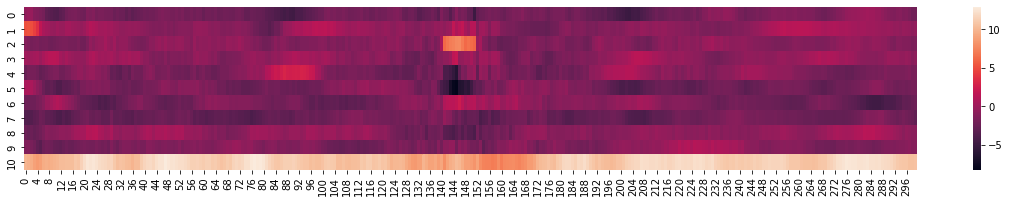

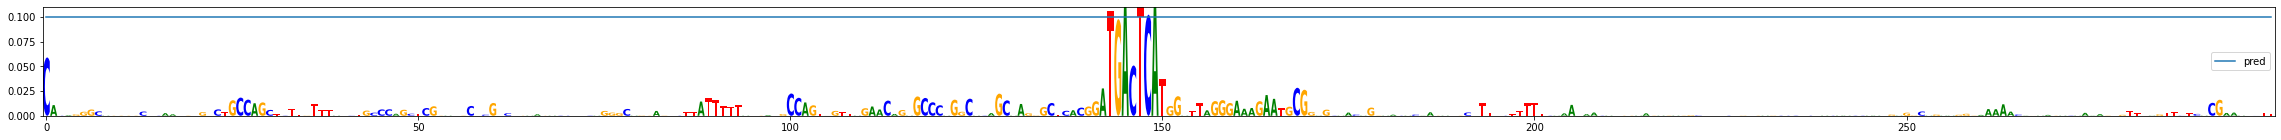

In [38]:
IDX=3

sns.heatmap(top_pred[IDX][900:1200].T)
plt.show()

fig, ax = plt.subplots(1, figsize=(40,2))
logomaker.Logo(pd.DataFrame(top_seq[IDX][900:1200], columns=['A','C','G','T']), ax=ax)
plt.plot(np.argmax(top_pred[IDX][900:1200,], -1)/100, label='pred')
ax.set_ylim(0,.11)
plt.legend()
plt.show()

### downweight the loss for background 

In [ ]:
def motif_loss_wrapper(background_weight=0.1,background_labels_index=-1):
    print("background_weight: ",background_weight)
    def motif_loss(y_true,logits):
        eps=1e-5
        y_pred = tf.nn.softmax(logits, axis=-1)
        num_classes = y_pred.shape[-1]
        cce_loss = -num_classes*(y_true*tf.math.log(y_pred+eps))
        weight_vector = [1] * num_classes
        weight_vector[background_labels_index] = background_weight
        weight_vector = np.array(weight_vector)
        weighted_cce_loss = cce_loss * weight_vector
        return tf.math.reduce_mean(weighted_cce_loss) * 100
    return motif_loss